# Train Multi-Head Attention



In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch import optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F
import torch.nn as nn

from tqdm.notebook import trange
from tqdm import tqdm
import torch.utils.data.dataloader as dataloader

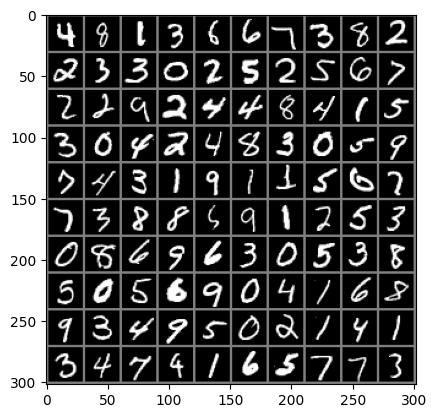

In [3]:
# Folder where the dataset is used
data_set_root = "../data"

# Downloading the mnist (training set)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
dataset = datasets.MNIST(data_set_root, train=True, download=True, transform=transform)

# Selecting randomly 100 examples
number_of_examples = 100
rand_perm = torch.randperm(dataset.data.shape[0])[:number_of_examples]
dataset_tensor = torch.cat([dataset.__getitem__(i)[0].reshape(1,-1) for i in rand_perm])

out = torchvision.utils.make_grid(dataset_tensor.reshape(-1, 1, 28, 28), 10, normalize=True, pad_value=0.5)
plt.imshow(out.numpy().transpose(1,2,0))

Import the model from the models folder:

In [4]:
import sys
sys.path.append('..')
from models.attention import Attention

Defining properties: 

In [5]:
# Define the size of each vector 
embed_dim = 256 

# Number of heads
number_of_heads = 1

# batch size
batch_size = 64 

Defining the device:

In [6]:
device = torch.device(0 if torch.cuda.is_available() else 'cpu')
print("Device is: ", device)

Device is:  cpu


In [7]:
train_loader = dataloader.DataLoader(dataset, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)

In [8]:
# Instance of the model with Adam as optimizer 
mha_model = Attention(number_of_examples=number_of_examples, embed_dim=embed_dim, number_of_heads=number_of_heads).to(device)
optimizer = optim.Adam(mha_model.parameters(), lr=1e-4)

loss_logger = []

# Duplicating the data value tensor per batch 
values_tensor = dataset_tensor.unsqueeze(0).expand(batch_size, number_of_examples, -1).to(device)

## Training Loop

In [9]:
# Model set to training mode 
mha_model.train()

# Loop through 10 epochs
for _ in trange(10, leave=False):
    # Iterate over the training data loader
    for data, _train_loader in tqdm(train_loader, leave=False):
        # Reshape the input data and move it to the specified device
        q_img = data.reshape(data.shape[0], 1, -1).to(device)

        # Perform forward pass through the Multi-Head Attention model
        attn_output, attn_output_weights = mha_model(q_img, values_tensor)

        # Calculate the mean squared error loss between the output and input images
        loss = (attn_output - q_img).pow(2).mean()

        # Zero the gradients, perform backward pass, and update model parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Append the current loss value to the loss logger
        loss_logger.append(loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Loss

In [ ]:
plt.plot(loss_logger[100:])
print("Minimum MSE loss %.4f" % np.min(loss_logger))